<a href="https://colab.research.google.com/github/skorpiom/traffic_sign_rec/blob/master/traffic_sign_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!rm -rf sample_data
!rm -rf train_and_valid_signs

In [0]:
%tensorflow_version 2.x
import os
import numpy as np
import pandas as pd
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG16

np.set_printoptions(precision = 6, suppress = True)

In [0]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip
!unzip -q GTSRB-Training_fixed.zip

In [4]:
base_dir = './GTSRB/Training'
raw_no_of_files = {}
classes = []
for n in range(0,43):
  if n<10:
    classes.append("0000"+str(n))
  else:
    classes.append("000"+str(n))

for dir in classes:
  raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir,dir)))

raw_no_of_files.items()

dict_items([('00000', 151), ('00001', 1501), ('00002', 1501), ('00003', 961), ('00004', 1321), ('00005', 1261), ('00006', 301), ('00007', 961), ('00008', 961), ('00009', 991), ('00010', 1351), ('00011', 901), ('00012', 1411), ('00013', 1441), ('00014', 541), ('00015', 421), ('00016', 301), ('00017', 751), ('00018', 811), ('00019', 151), ('00020', 241), ('00021', 241), ('00022', 271), ('00023', 361), ('00024', 181), ('00025', 1021), ('00026', 421), ('00027', 181), ('00028', 361), ('00029', 181), ('00030', 301), ('00031', 541), ('00032', 181), ('00033', 481), ('00034', 301), ('00035', 811), ('00036', 271), ('00037', 151), ('00038', 1381), ('00039', 211), ('00040', 241), ('00041', 181), ('00042', 181)])

In [0]:
data_dir = './train_and_valid_signs'
dirs_train = []
dirs_valid = []

train_dir = os.path.join(data_dir,'train') #katalog treningowy
valid_dir = os.path.join(data_dir,'valid') #katalog walidacyjny

for n in range(0,43):
  dirs_train.append(os.path.join(train_dir,classes[n])) #sciezki z katalogami docelowymi zbior treningowy

for n in range(0,43):
  dirs_valid.append(os.path.join(valid_dir,classes[n])) #sciezki z katalogami docelowymi zbior walidacyjny

if not os.path.exists(data_dir):
  os.mkdir(data_dir)
  
for directory in (train_dir,valid_dir):
  if not os.path.exists(directory):
    os.mkdir(directory)

for directory in dirs_train:
  if not os.path.exists(directory):
    os.mkdir(directory)

for directory in dirs_valid:
  if not os.path.exists(directory):
    os.mkdir(directory)

#DISPLAY INDICATED SIGN

./GTSRB/Training/00000/00001_00010.ppm


(-0.5, 35.5, 34.5, -0.5)

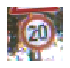

In [6]:
img_path = os.path.join('./GTSRB','Training','00000','00001_00010.ppm')
print(img_path)
img = image.load_img(img_path)
plt.figure(figsize=(1,1))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [6]:
sign_fnames = []
for ind in range(0,43):
  sign_fnames.append(os.listdir(os.path.join(base_dir,classes[ind])))  

print('00000 liczba obiektow: ',len(sign_fnames[0]))
print('00001 liczba obiektow: ',len(sign_fnames[1]))

00000 liczba obiektow:  151
00001 liczba obiektow:  1501


In [0]:
for i,fname in enumerate(sign_fnames):
  for j,name in enumerate(fname):
    if j<=0.8*int(np.floor(len(fname))):
      src = os.path.join(base_dir,classes[i],name)
      dst = os.path.join(dirs_train[i],name)
      shutil.copyfile(src,dst)
    if 0.8*int(np.floor(len(fname))) < j <= len(fname):
      src = os.path.join(base_dir,classes[i],name)
      dst = os.path.join(dirs_valid[i],name)
      shutil.copyfile(src,dst)

In [8]:
print('00000 zbior treningowy ',len(os.listdir(dirs_train[0])))
print('00000 zbior walidacyjny ',len(os.listdir(dirs_valid[0])))

print('00001 zbior treningowy ',len(os.listdir(dirs_train[1])))
print('00001 zbior walidacyjny ',len(os.listdir(dirs_valid[1])))

00000 zbior treningowy  121
00000 zbior walidacyjny  30
00001 zbior treningowy  1201
00001 zbior walidacyjny  300


#AUGMENTACJA DANYCH

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255.,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

valid_datagen = ImageDataGenerator(rescale = 1./255.) #przeskalowanie danych

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size=(32,32),
                                                    batch_size = 8,
                                                    class_mode='categorical')
valid_generator = train_datagen.flow_from_directory(directory = valid_dir,
                                                    target_size=(32,32),
                                                    batch_size = 8,
                                                    class_mode='categorical')

Found 21319 images belonging to 43 classes.
Found 5321 images belonging to 43 classes.


#TRANSFER LEARNING

In [30]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape=(32,32,3))
conv_base.trainable = False

def print_layers(model):
  for layer in model.layers:
    print(f'layer_name {layer.name:13} trainable: {layer.trainable}')

set_trainable = False
for layer in conv_base.layers:
  if layer.name =='block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

print_layers(conv_base)


layer_name input_7       trainable: False
layer_name block1_conv1  trainable: False
layer_name block1_conv2  trainable: False
layer_name block1_pool   trainable: False
layer_name block2_conv1  trainable: False
layer_name block2_conv2  trainable: False
layer_name block2_pool   trainable: False
layer_name block3_conv1  trainable: False
layer_name block3_conv2  trainable: False
layer_name block3_conv3  trainable: False
layer_name block3_pool   trainable: False
layer_name block4_conv1  trainable: False
layer_name block4_conv2  trainable: False
layer_name block4_conv3  trainable: False
layer_name block4_pool   trainable: False
layer_name block5_conv1  trainable: True
layer_name block5_conv2  trainable: True
layer_name block5_conv3  trainable: True
layer_name block5_pool   trainable: True


In [31]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units = 1024, activation = 'relu'))
model.add(layers.Dense(units = 43, activation = 'softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_11 (Dense)             (None, 43)                44075     
Total params: 15,284,075
Trainable params: 569,387
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
history = model.fit_generator(generator=train_generator,
                              epochs = 50,
                              validation_data = valid_generator,
                              callbacks = [tensorboard])

#BUDOWA MODELU

In [35]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3,3),activation='relu',input_shape=(32, 32, 3)))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(units=1024, activation='relu'))
model.add(layers.Dense(units=43, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_7 (Flatten)          (None, 4096)             

In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
!rm -rf logs
!mkdir logs
tensorboard = TensorBoard(log_dir='logs')

In [0]:
history = model.fit_generator(generator=train_generator,
                              epochs = 50,
                              validation_data = valid_generator,
                              callbacks = [tensorboard])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2665 steps, validate for 666 steps
Epoch 1/50
2665/2665 [==============================] - 31s 12ms/step - loss: 2.8110 - accuracy: 0.2087 - val_loss: 2.3439 - val_accuracy: 0.3142
Epoch 2/50
2665/2665 [==============================] - 29s 11ms/step - loss: 2.0143 - accuracy: 0.3926 - val_loss: 1.7107 - val_accuracy: 0.4794
Epoch 3/50
2665/2665 [==============================] - 29s 11ms/step - loss: 1.5907 - accuracy: 0.4994 - val_loss: 1.4558 - val_accuracy: 0.5304
Epoch 4/50
2665/2665 [==============================] - 29s 11ms/step - loss: 1.3363 - accuracy: 0.5745 - val_loss: 1.1708 - val_accuracy: 0.6151
Epoch 5/50
2665/2665 [==============================] - 29s 11ms/step - loss: 1.1583 - accuracy: 0.6255 - val_loss: 1.1021 - val_accuracy: 0.6439
Epoch 6/50
2665/2665 [==============================] - 29s 11ms/step - loss: 1.0426 - accuracy: 0.6632 - val_loss: 1.0056 - val_accuracy: 0.6659
Epoch 7/50
2665/2665 [=======

In [0]:
%load_ext tensorboard
!tensorboard dev upload --logdir logs